<a href="https://colab.research.google.com/github/vhinatav/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Trash Detection <b> </h1></center>
This object detection model detects the type of trash in the image, and it labels the object with the colour of the trash bin it should go to.


# Libraries

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Dataset






In [22]:
#Path
label_dir= "/content/trash_data/labels"
image_dir="/content/trash_data/images"

**Data Structure**
- trash_data
  - images
    - train
    - val
  - labels
    - train
    - val


**Number of Data**
- train = 179
  - black × 53 / blue × 53 / yellow × 26 / green × 47
- val = 97
  - black × 27 / blue × 27 / yellow × 14 / green × 29

**Colour Description**
- black: landfill
- blue: recycle
- yellow: mix paper
- green: compost

# YOLO

In [23]:
#Path
label_dir= "/content/trash_data/labels"
image_dir="/content/trash_data/images"

In [24]:
from ultralytics import YOLO

In [25]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)


# Training

In [26]:
#Pretrained model
model = YOLO('yolov8s.pt')

In [27]:
#Detailed architecrure
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

Config.yaml:

In [28]:
%%writefile config.yaml
path: /content/trash_data
train: /content/trash_data/images/train
#test: (test dataset folder path)
val: /content/trash_data/images/val

# Classes
nc: 4

# Class names
names:
  0: black
  1: blue
  2: yellow
  3: green

Overwriting config.yaml


In [29]:
#Original
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

#Hyperparameter Change (Higher learning rate)
#model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.001,imgsz=640)

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

train: Scanning /content/trash_data/labels/train.cache... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/trash_data/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.42G      1.161      2.951      1.485          6        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all         97        176      0.525      0.392      0.469      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.34G     0.9268      1.721       1.34         16        640: 100%|██████████| 23/23 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all         97        176      0.602      0.432      0.482      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.39G     0.9746      1.515      1.372         10        640: 100%|██████████| 23/23 [00:04<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all         97        176       0.63      0.523      0.589       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.35G     0.9971      1.451      1.366          5        640: 100%|██████████| 23/23 [00:07<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]

                   all         97        176      0.543      0.508      0.518      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.43G     0.9527      1.213       1.32         10        640: 100%|██████████| 23/23 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]

                   all         97        176      0.576      0.635      0.597      0.385



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


                   all         97        176      0.565      0.637      0.596      0.384
                 black         27         39      0.427      0.846      0.697      0.483
                  blue         27         58      0.789       0.81      0.883       0.65
                yellow         14         14      0.553      0.714      0.512      0.221
                 green         29         65       0.49      0.178      0.293      0.182
Speed: 0.8ms preprocess, 7.3ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f24ef00f10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Evaluation

In [14]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/trash_data/labels/val.cache... 97 images, 0 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


                   all         97        176      0.775      0.512      0.657       0.41
                 black         27         39      0.672      0.682       0.73       0.52
                  blue         27         58      0.975      0.677      0.911      0.701
                yellow         14         14      0.762      0.429      0.587      0.228
                 green         29         65      0.693      0.262      0.402      0.193
Speed: 0.4ms preprocess, 13.1ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/detect/train322


0.512191860188439

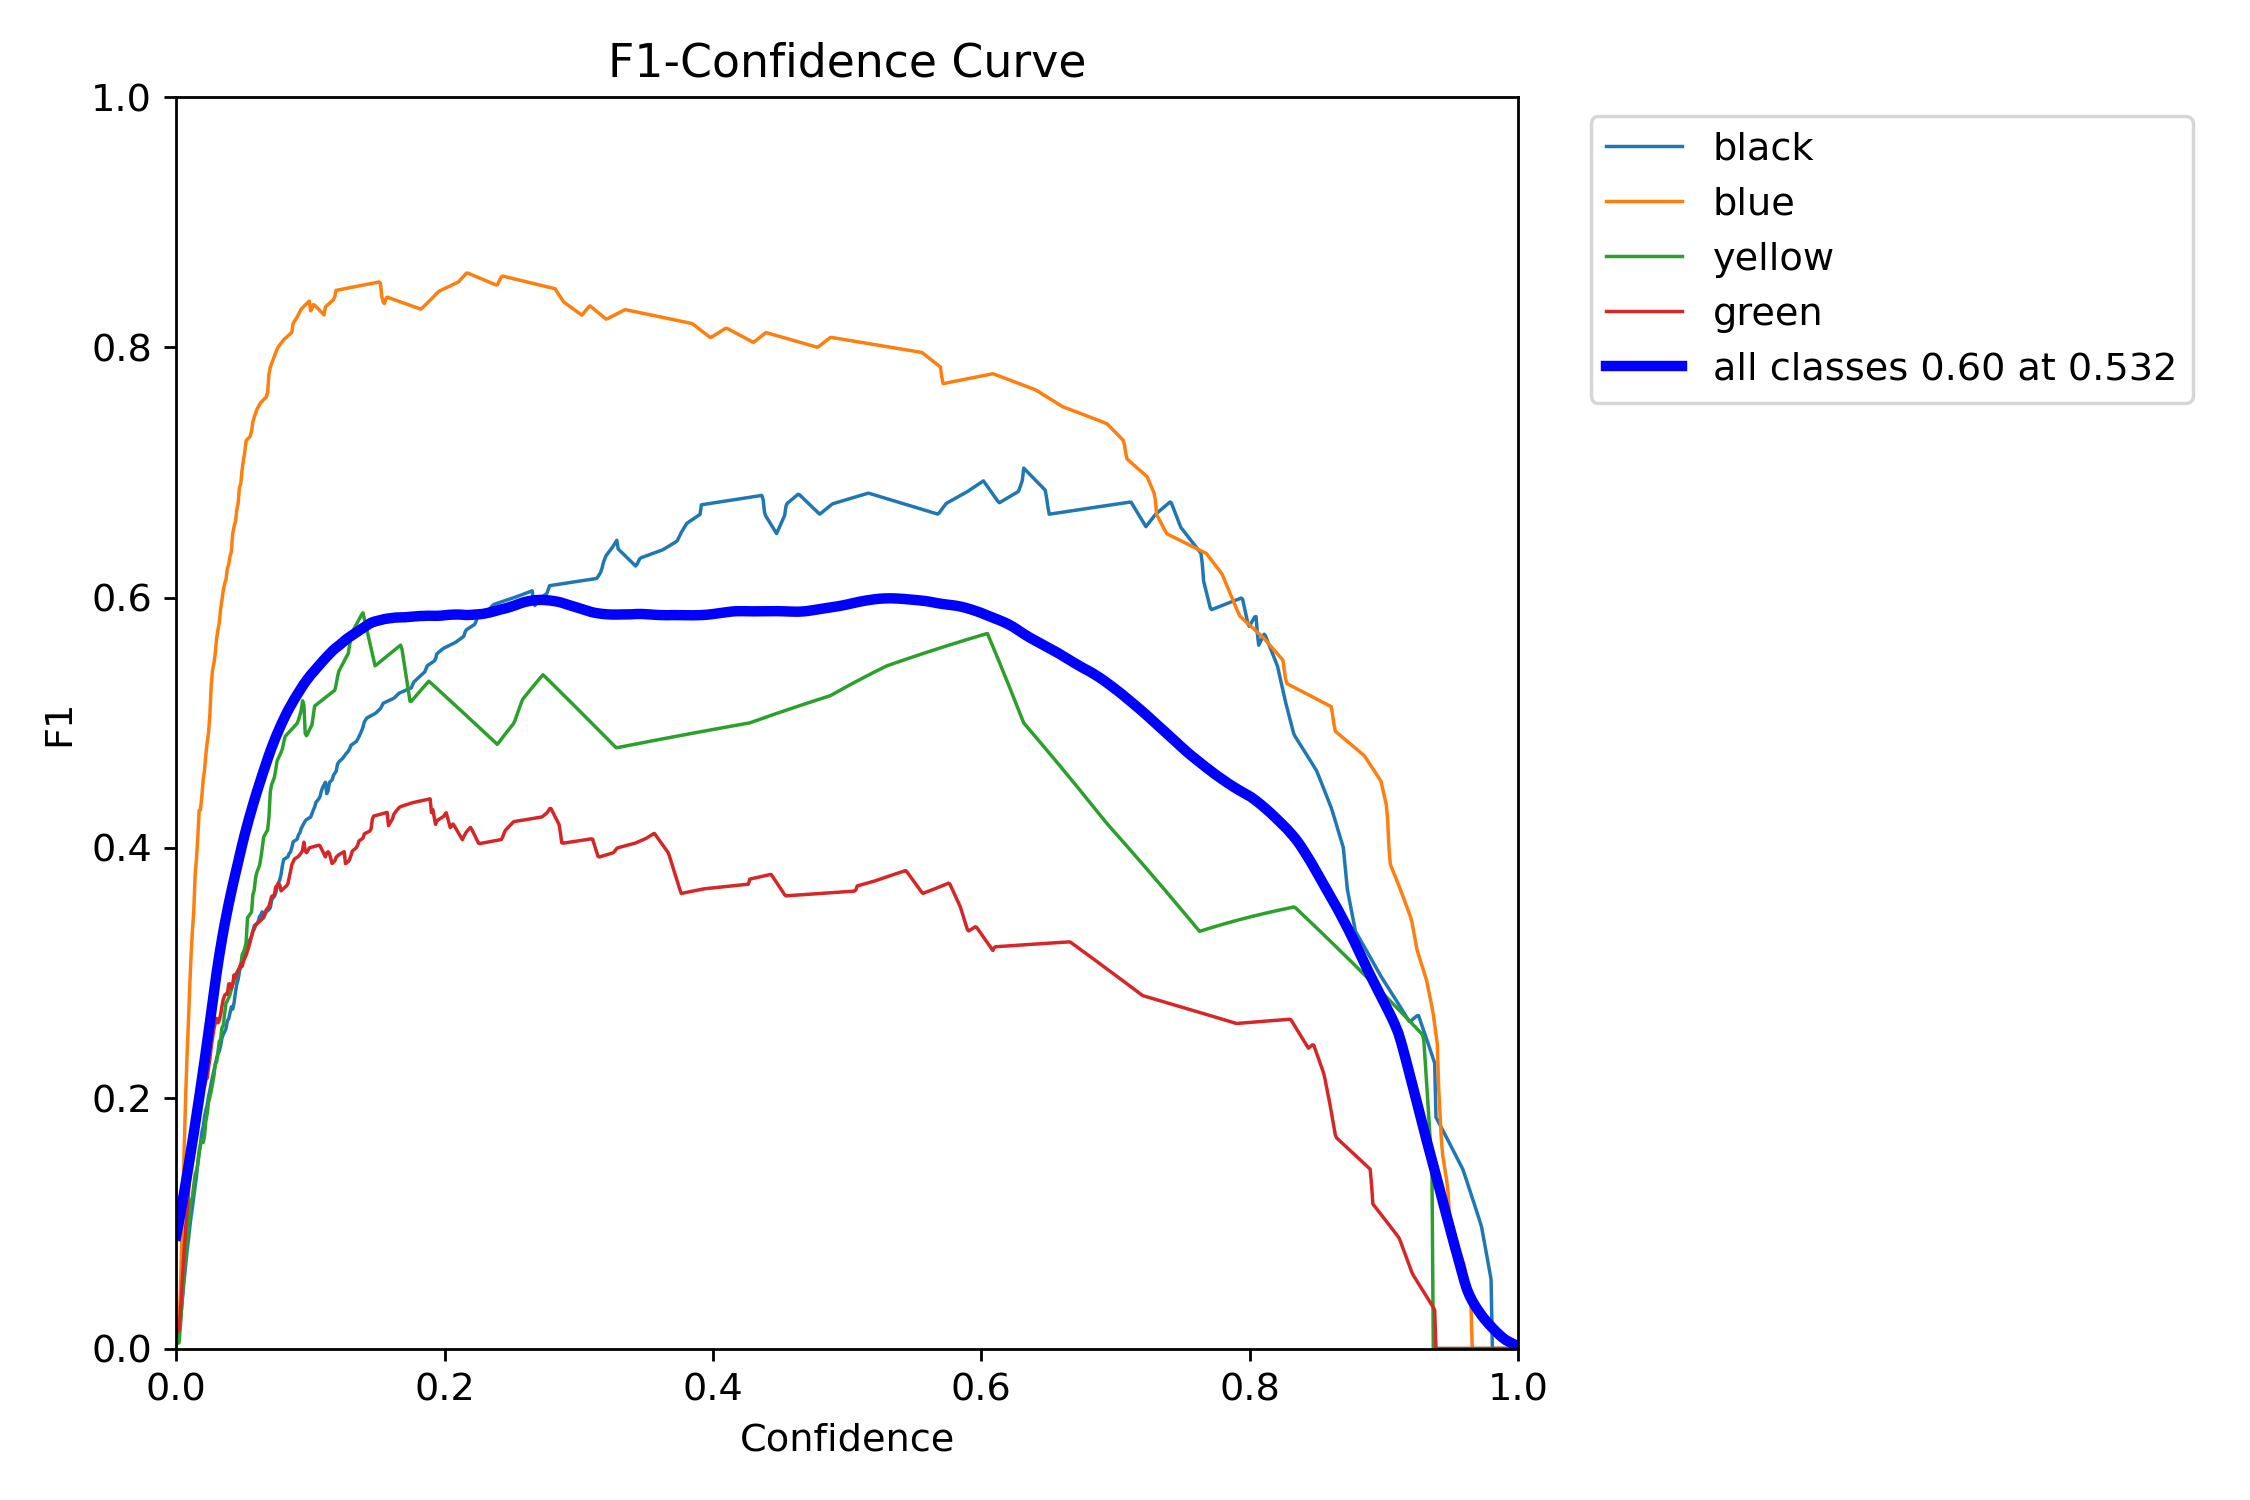

In [41]:
%matplotlib inline
from PIL import Image

#Confusion Matrix
Image.open('/content/runs/detect/evaluation (original)/confusion_matrix_normalized.png')
Image.open('/content/runs/detect/evaluation (new)/confusion_matrix_normalized.png')

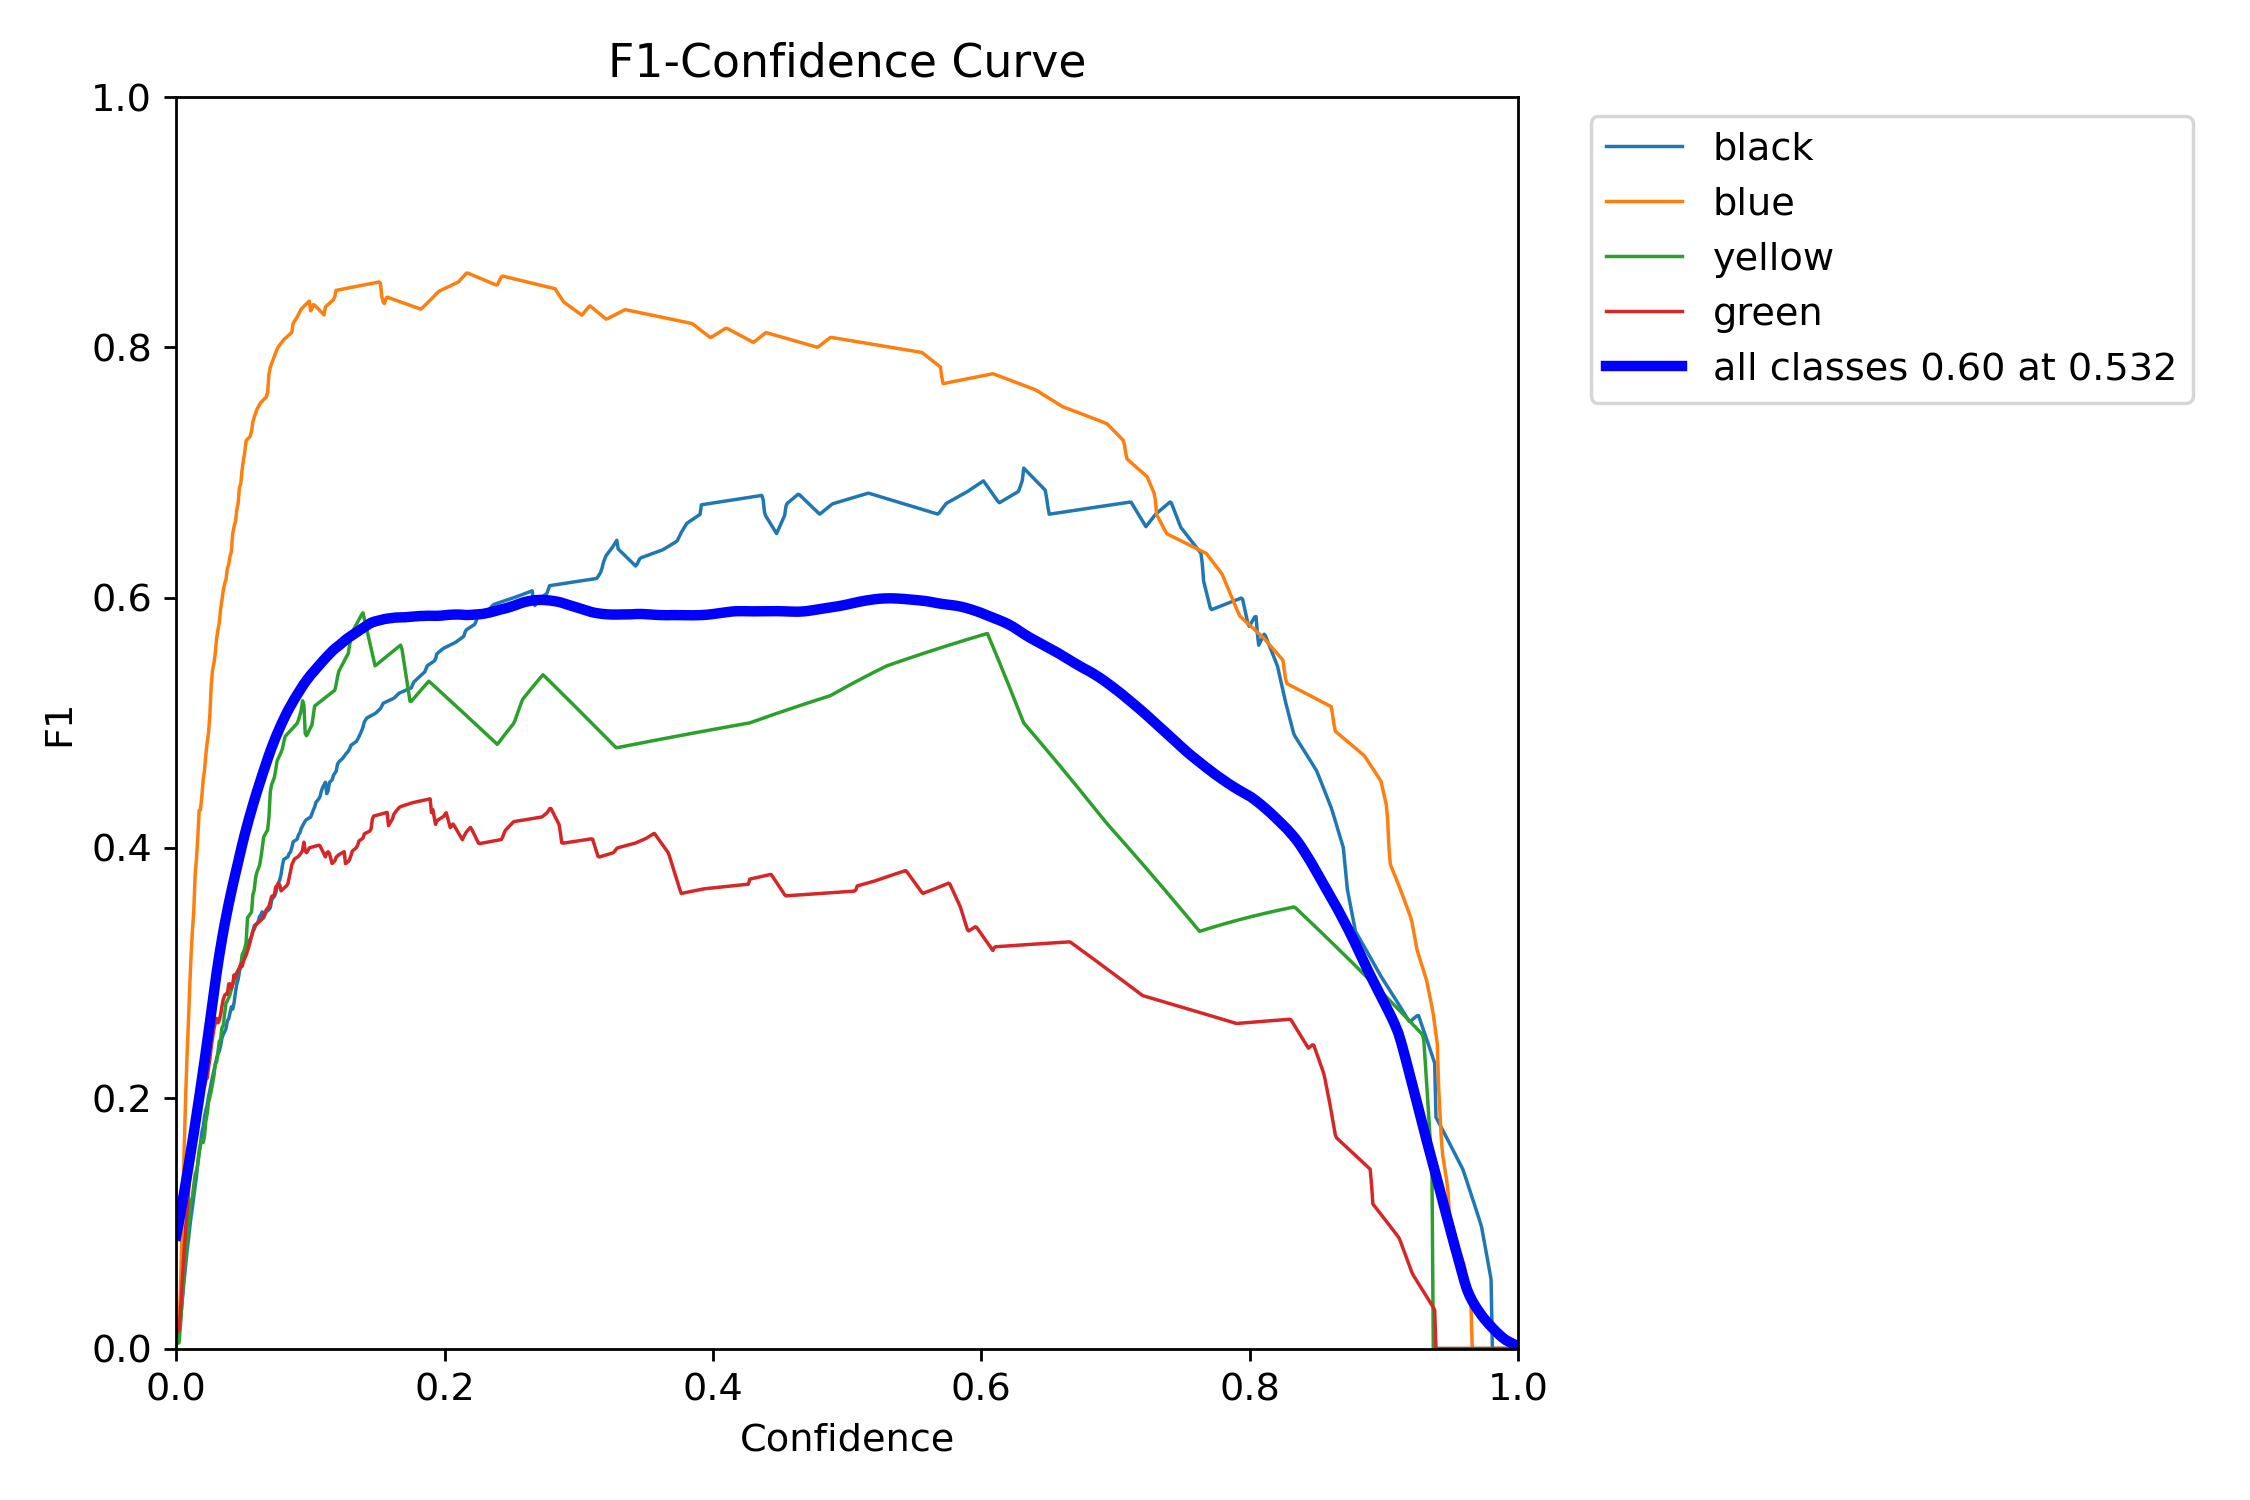

In [43]:
#F1 Curve
Image.open('/content/runs/detect/evaluation (original)/F1_curve.png')
Image.open('/content/runs/detect/evaluation (new)/F1_curve.png')

# Prediction

In [35]:
#model = YOLO('yolov8s.pt')

# Predict with the model with any image from internet?
results = model('path', save=True)


image 1/1 /content/example_images/test_7.jpg: 512x640 11 blacks, 4 blues, 13 greens, 53.5ms
Speed: 4.0ms preprocess, 53.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/train38


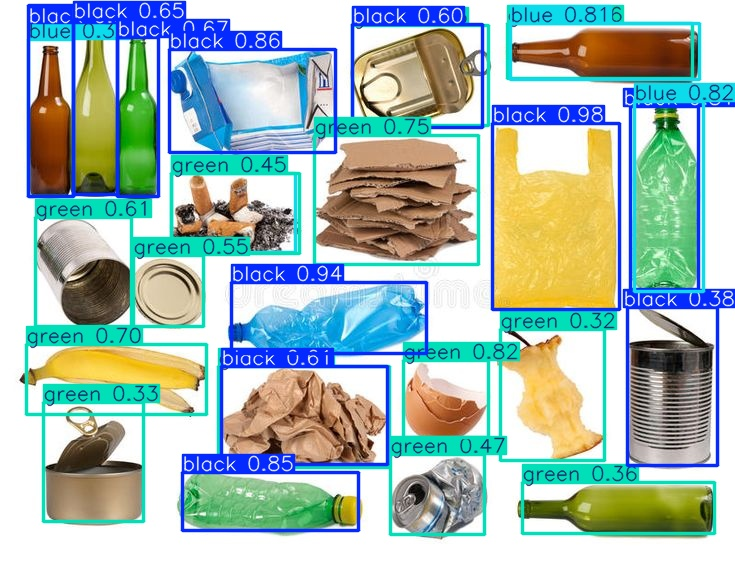

In [39]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

#Corrrect Output
Image.open('/content/runs/detect/output_correct/test_1.jpg')
Image.open('/content/runs/detect/output_correct/test_2.jpg')
Image.open('/content/runs/detect/output_correct/test_3.jpg')
Image.open('/content/runs/detect/output_correct/test_4.jpg')

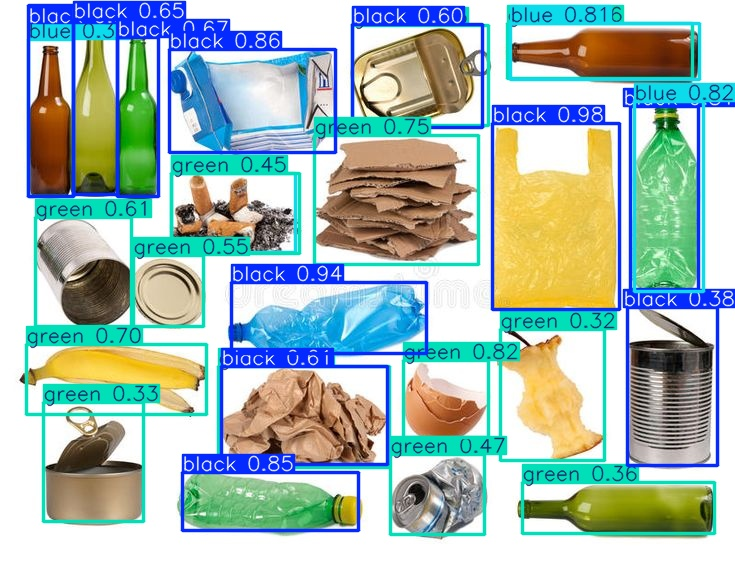

In [42]:
#Incorrect Output
Image.open('/content/runs/detect/output_incorrect/test_7.jpg')